## Predictive modeling of future customer demand trends

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

In [2]:
df = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MBAinfo_Retail_Clean_update.xlsx'
df = pd.read_excel(df)

df.head()

,Material,Year/Period,Retail_sales
0,110,2020-04-01,183175
1,111,2020-04-01,243
2,112,2020-04-01,2096
3,113,2020-04-01,1673
4,120,2020-04-01,178781


In [3]:
jdf = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MARA_Clean.xlsx'
jdf = pd.read_excel(jdf)

jdf = jdf[['Material','Material Group']]
jdf.head()

,Material,Material Group
0,1,TRAINING
1,110,MISC_FA
2,112,MISC_FA
3,113,MISC_FA
4,120,MISC_FA


In [4]:
# perform left join on the 'Material' column
left_join = pd.merge(df, jdf, on='Material', how='left')
left_join.head()

,Material,Year/Period,Retail_sales,Material Group
0,110,2020-04-01,183175,MISC_FA
1,111,2020-04-01,243,NaN
2,112,2020-04-01,2096,MISC_FA
3,113,2020-04-01,1673,MISC_FA
4,120,2020-04-01,178781,MISC_FA


In [5]:
df = left_join
df = df.rename(columns={'Year/Period':'Date', 'Retail_sales':'Retail_Value'})

In [6]:
# extract the rows of each Material Group

TREATMENT = df[df['Material Group'] == 'TREATMENT']

TABLETS = df[df['Material Group'] == 'TABLETS']

BANDAGES = df[df['Material Group'] == 'BANDAGES']

HANDPROT = df[df['Material Group'] == 'HANDPROT']

EYEPROT = df[df['Material Group'] == 'EYEPROT']

DRESSING = df[df['Material Group'] == 'DRESSING']

EMERG_FA = df[df['Material Group'] == 'EMERG_FA']

INSTRUMNT = df[df['Material Group'] == 'INSTRUMNT']

SKINCARE = df[df['Material Group'] == 'SKINCARE']

In [7]:
# Change Material_Group
Material_Group = TABLETS

In [8]:
# Each Material Group's retail value grouped by each date !!!!!!!!!!!!!
gdf = Material_Group.groupby('Date')['Retail_Value'].sum()
gdf = gdf.reset_index()
gdf.head()

,Date,Retail_Value
0,2020-04-01,312790
1,2020-05-01,262892
2,2020-06-01,315927
3,2020-07-01,324364
4,2020-08-01,298337


In [9]:
gdf.Date = pd.to_datetime(gdf.Date)

gdf = gdf.set_index("Date")
gdf.head()

,Retail_Value
Date,
2020-04-01,312790
2020-05-01,262892
2020-06-01,315927
2020-07-01,324364
2020-08-01,298337


In [10]:
gdf.tail()

,Retail_Value
Date,
2022-11-01,546191
2022-12-01,740570
2023-01-01,644505
2023-02-01,523822
2023-03-01,584012


### Rolling Statistics

<AxesSubplot: xlabel='Date'>

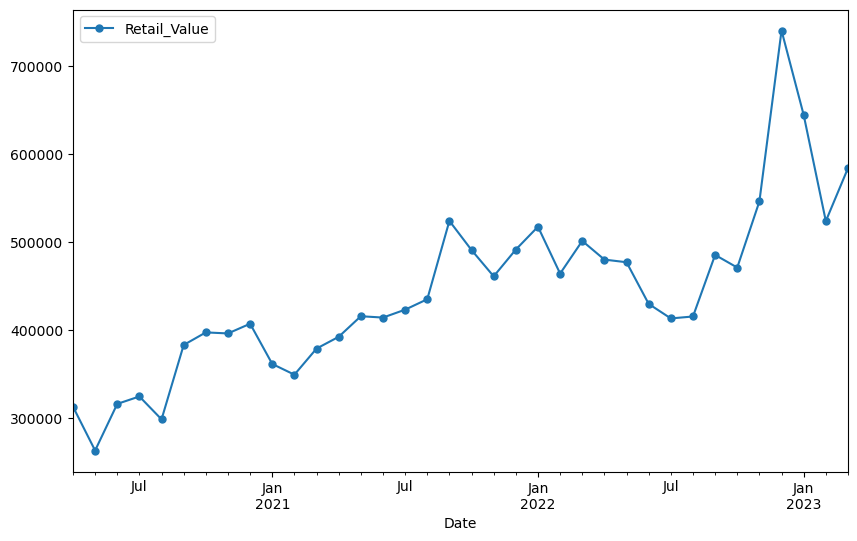

In [11]:
gdf['Retail_Value'].plot(figsize = (10,6), legend=True, marker='o', markersize=5)

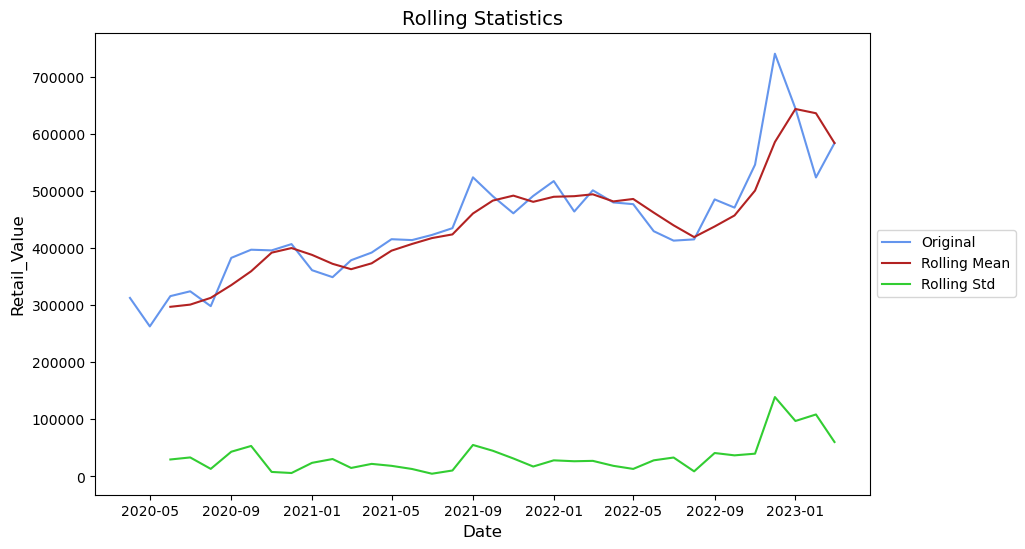

In [12]:
rolling_mean = gdf.rolling(window=3).mean()
rolling_std = gdf.rolling(window=3).std()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(gdf, color='cornflowerblue', label='Original')
ax.plot(rolling_mean, color='firebrick', label='Rolling Mean')
ax.plot(rolling_std, color='limegreen', label='Rolling Std')

ax.set_xlabel('Date', size=12)
ax.set_ylabel('Retail_Value', size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Rolling Statistics', size=14)

plt.show()

### Acf (Autocorrelation)

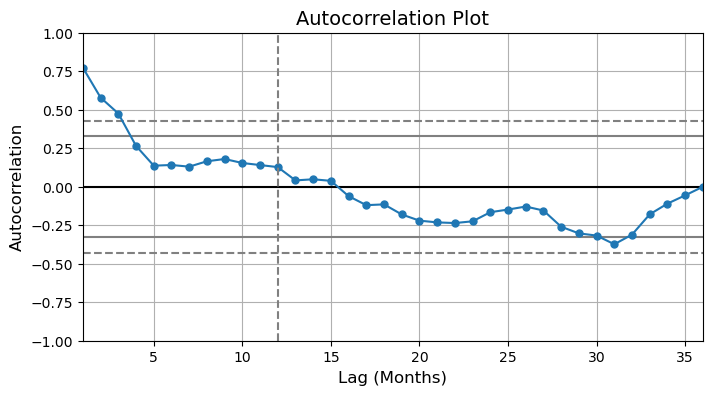

In [13]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

plt.figure(figsize=(8, 4))
pd.plotting.autocorrelation_plot(gdf['Retail_Value'], marker='o', markersize=5)
plt.axvline(x=12, linestyle='--', color='grey')
plt.xlabel('Lag (Months)', fontsize=12)  # explicitly reference the xlabel function from matplotlib.pyplot
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation Plot', fontsize=14)
plt.show()

### Pacf (Partial Autocorrelation)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x400 with 0 Axes>

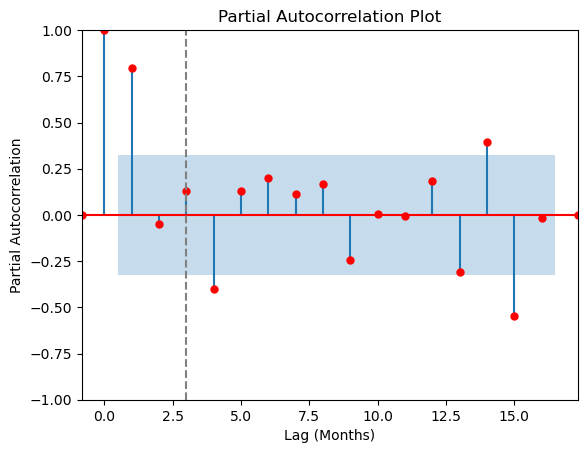

In [14]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
# assume gdf is a pandas DataFrame containing the time series data

plt.figure(figsize=(8, 4))
plot_pacf(gdf['Retail_Value'], lags=16, marker='o', markersize=5, color='red')
plt.axvline(x=3, linestyle='--', color='grey')
plt.xlabel('Lag (Months)')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.show()

### Decomposition

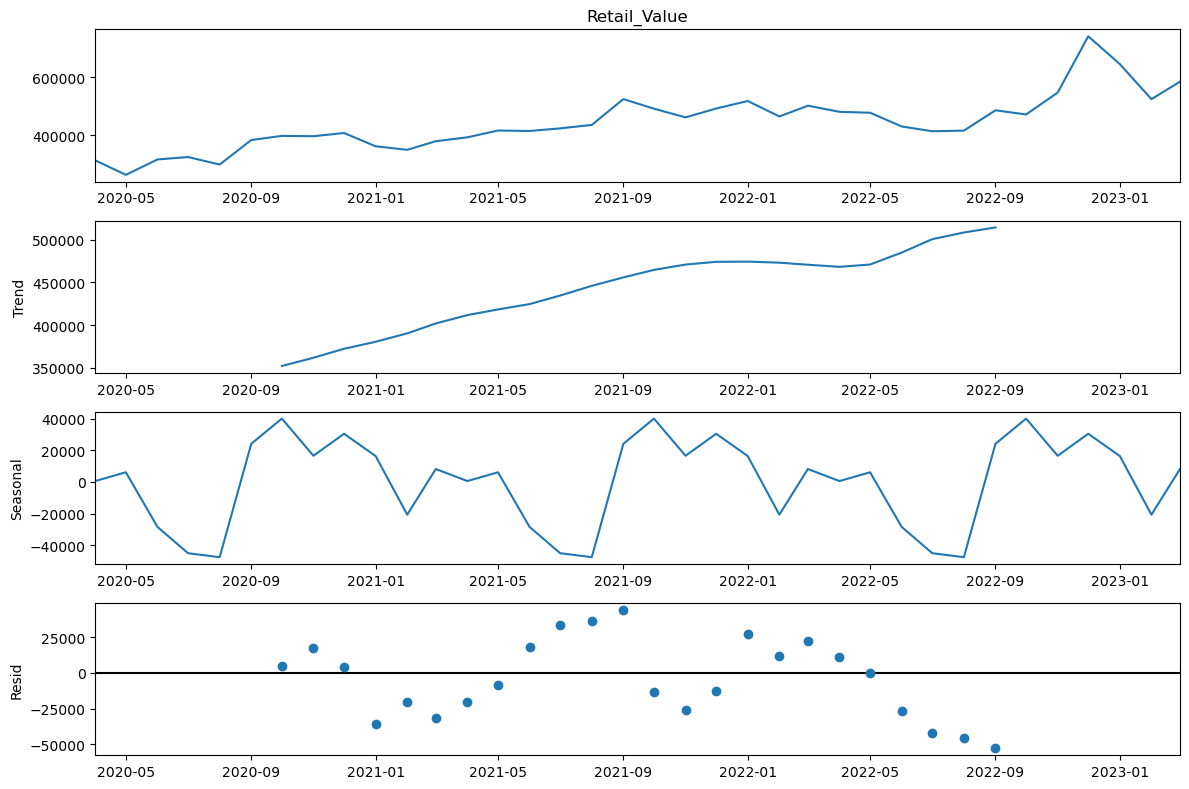

In [15]:
rcParams['figure.figsize'] = 12, 8
dec = seasonal_decompose(gdf["Retail_Value"], model = "add")
dec.plot();

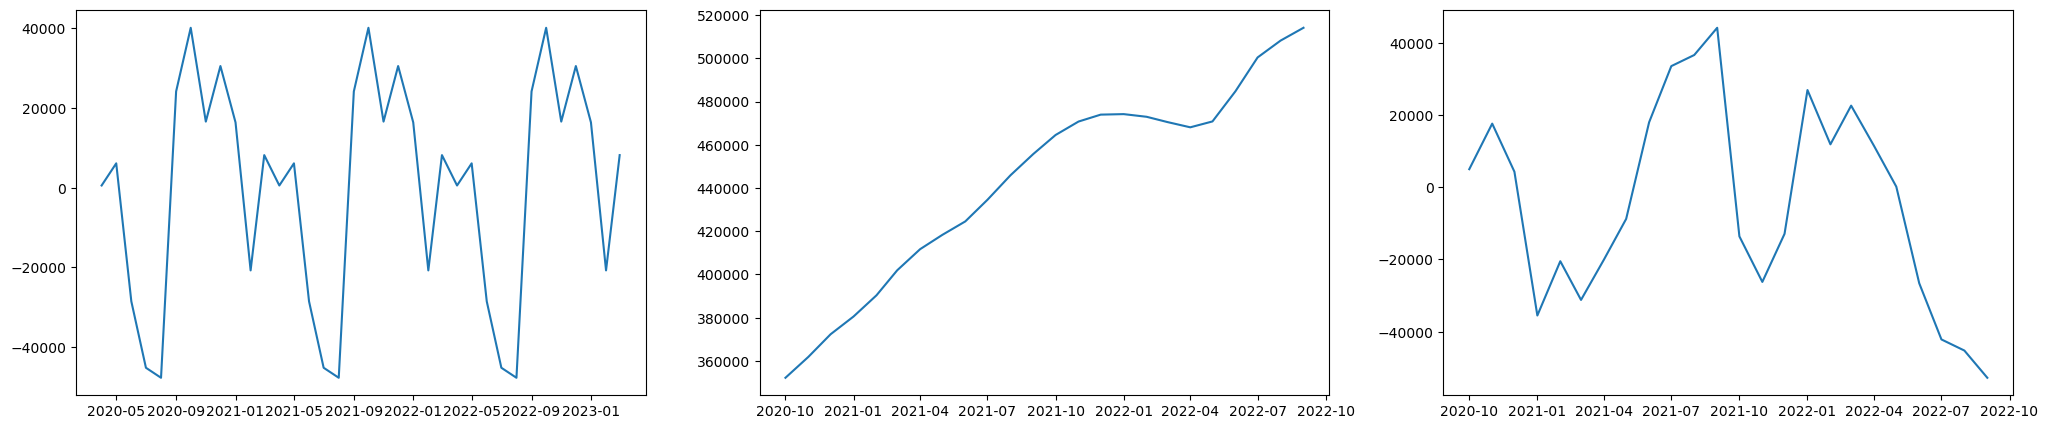

In [16]:
plt.figure(figsize = (25, 5))
a = seasonal_decompose(gdf["Retail_Value"], model = "add")
plt.subplot(1, 3, 1)
plt.plot(dec.seasonal)

plt.subplot(1, 3, 2)
plt.plot(dec.trend)

plt.subplot(1, 3, 3)
plt.plot(dec.resid)

plt.show()

In [17]:
# check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(gdf['Retail_Value'])
print('ADF Statistic: {:.3f}'.format(result[0]))
print('p-value: {:.3f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic: -1.743
p-value: 0.409
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


## Forecasting Model

**ARIMA Model** stands for Auto-Regressive Integrated Moving Average.<br> It is is used for predicting future trends on a time series data. It is model that form of regression analysis.

**Auto-Regressive** models predict future behavior using past behavior where there is some correlation between past and future data.

**Integration** is the difference between present and previous observations. It is used to make the time series stationary.

**Moving Average** is a statistical method that takes the updated average of values to help cut down on noise. It takes the average over a specific interval of time

**p**: Value just before convergence in pacf. ( =3 )<br>
**d** : Check whether there is a trend by adf test and visual confirmation of the trend ( =0 )<br>
**q** : value just before convergence in acf ( =1)<br>
**P** : Check how many times the seasonality cycle was repeated in the pacf ( =0 )<br>
**D**: Check whether there is seasonality, 1 or 0 ( =0 ) depending on the need for seasonality difference <br>
**Q**: Check how many times the seasonal cycle based on acf has been repeated (=1)<br>
**m** : seasonal period ( =12 )

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = gdf[:len(gdf)-12]
test_data = gdf[len(gdf)-12:]

arima_model = SARIMAX(gdf['Retail_Value'], order = (1,0,4), seasonal_order = (2,0,0,12))
arima_result = arima_model.fit()
arima_result.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52013D+02    |proj g|=  4.86184D+02

At iterate    5    f=  1.25508D+01    |proj g|=  5.41374D-01

At iterate   10    f=  1.23975D+01    |proj g|=  2.20007D-02

At iterate   15    f=  1.23612D+01    |proj g|=  5.05815D-02

At iterate   20    f=  1.23382D+01    |proj g|=  3.92898D-02

At iterate   25    f=  1.23323D+01    |proj g|=  4.10452D-03

At iterate   30    f=  1.23322D+01    |proj g|=  8.10250D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Retail_Value   No. Observations:                   36
Model:             SARIMAX(1, 0, 4)x(2, 0, [], 12)   Log Likelihood                -443.959
Date:                             Thu, 27 Apr 2023   AIC                            903.918
Time:                                     14:37:55   BIC                            916.586
Sample:                                 04-01-2020   HQIC                           908.339
                                      - 03-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9939      0.037     26.876      0.000       0.921       1.066
ma.L1          0.0335      0.382      0.088      0.930      -0.715       0.782
ma.L2         -0.4668      0.633     -0.738      0.461      -1.707       0.773
ma.L3         -0.0738      0.495     -0.149      0.882      -1.044       0.897
ma.L4          0.0969      0.664      0.146      0.884      -1.204       1.398
ar.S.L12       0.2570      0.672      0.382      0.702      -1.061       1.575
ar.S.L24       0.1203      1.063      0.113      0.910      -1.964       2.205
sigma2      3.634e+09   7.75e-11   4.69e+19      0.000    3.63e+09    3.63e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                23.38
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               3.53   Skew:                             1.27
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+37. Standard errors may be unstable.
"""

In [27]:
arima_pred = arima_result.predict(start = len(train_data), end = len(gdf)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2022-04-01    518023.358520
2022-05-01    461462.337090
2022-06-01    492101.928061
2022-07-01    429052.883309
2022-08-01    435216.984964
2022-09-01    459630.926500
2022-10-01    481974.668293
2022-11-01    448878.524129
2022-12-01    557582.233302
2023-01-01    702287.306914
2023-02-01    530864.000710
2023-03-01    557392.632691
Freq: MS, Name: ARIMA Predictions, dtype: float64

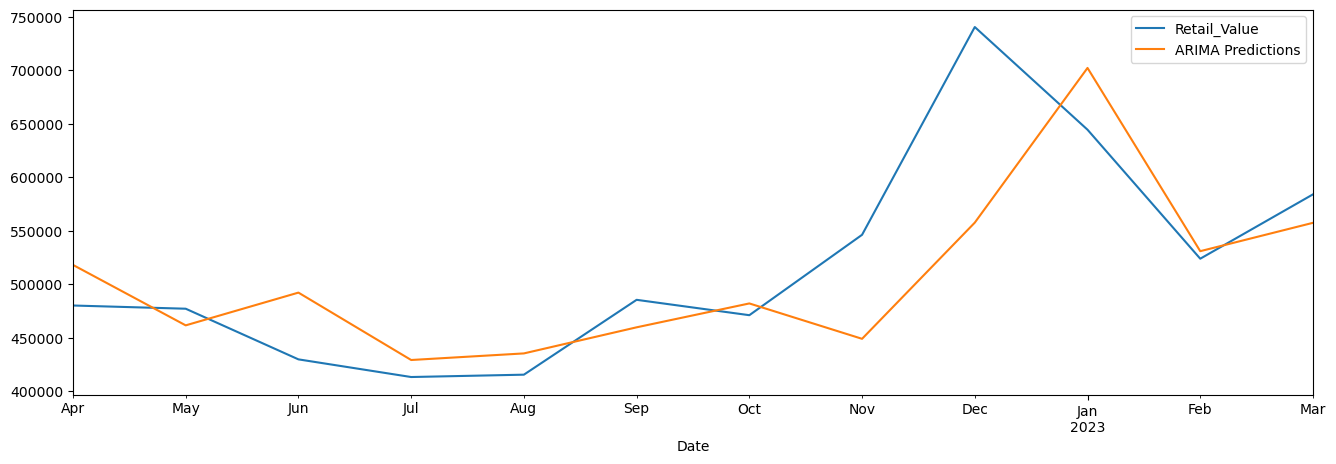

In [28]:
test_data['Retail_Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [29]:
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_data['Retail_Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = gdf['Retail_Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 4505735516.5971575
RMSE Error: 67124.77572846823
Mean: 442437.80555555556


In [30]:
arima_pred_f = arima_result.predict(start = len(gdf), end = len(gdf)+12, typ="levels").rename("ARIMA Predictions")
arima_pred_f

2023-04-01    603832.862994
2023-05-01    585716.832321
2023-06-01    568176.514763
2023-07-01    565093.801383
2023-08-01    564587.113330
2023-09-01    590822.606980
2023-10-01    580670.052133
2023-11-01    593951.983692
2023-12-01    645137.013572
2024-01-01    621150.917509
2024-02-01    581307.620618
2024-03-01    598854.130908
2024-04-01    599013.577077
Freq: MS, Name: ARIMA Predictions, dtype: float64

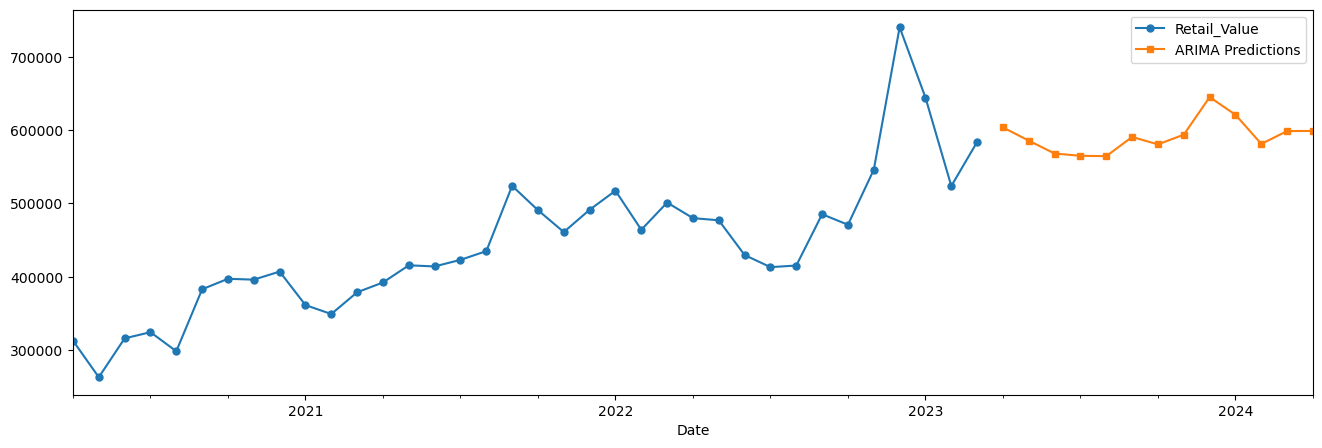

In [31]:
gdf['Retail_Value'].plot(figsize = (16,5), legend=True, marker='o', markersize=5)
arima_pred_f.plot(legend = True, marker='s', markersize=5);

In [32]:
pdf = arima_pred_f.to_frame(name='Retail_Value')
pdf.head()

,Retail_Value
2023-04-01,603832.862994
2023-05-01,585716.832321
2023-06-01,568176.514763
2023-07-01,565093.801383
2023-08-01,564587.113330


In [33]:
udf = pd.concat([gdf, pdf])

udf.reset_index(inplace=True)
udf = udf.rename(columns = {'index':'Date'})

In [34]:
udf.head()

,Date,Retail_Value
0,2020-04-01,312790.0
1,2020-05-01,262892.0
2,2020-06-01,315927.0
3,2020-07-01,324364.0
4,2020-08-01,298337.0


In [35]:
udf.to_csv('/Users/sseyeoni/Documents/jupyter/Cintas/Forecasting/Results/Retail_Predictive_Model_TABLETS.csv', index=False)